# **Lasso**

---

## 0. Importing dependencies

In [56]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


import warnings
warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [57]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [58]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Angola', 'Country_Slovakia', 'Country_Saudi Arabia', 'Country_Georgia', 'Country_El Salvador', 'Country_Bangladesh', 'Country_Malta', 'Country_Costa Rica', 'Country_Peru', 'Country_Viet Nam', 'Country_Venezuela', 'Country_Sri Lanka', 'Country_Philippines', 'Country_Jordan', 'Country_Bosnia-Herz.', 'Country_Armenia', 'Country_Yemen', 'Country_Zimbabwe', 'Country_Estonia', 'Country_Serbia', 'Country_Croatia', 'Country_United Arab Emirates', 'Country_Nomadic', 'Country_Uzbekistan', 'Country_Lebanon', 'Country_Andorra', 'Country_Botswana', 'Country_Mongolia', 'Country_Cyprus', 'Country_Kenya', 'Country_Kosovo', 'Country_New Zealand', 'Country_Tanzania', 'Country_North Macedonia', 'Country_Latvia', 'Ethnicity_North American / Central American', 'Country_Paraguay', 'Country_Azerbaijan'}
Columns in the test set that aren't in the train set: {'Country_Trinidad and Tobago', "Country_CÃ´te d'Ivoire", 'Country_Republic of Korea', 'Co

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [59]:
'''# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

baseline_train_df.head()'''

'# Assuming you have a DataFrame called \'df\'\nbaseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]\n\n# Add Job_title columns to the baseline_cols list\nJob_title = [\'Developer, game or graphics\', \'Blockchain\', \'Developer, QA or test\', \'Developer, back-end\', \'Student\', \n             \'Project manager\', \'Data or business analyst\', \'Cloud infrastructure engineer\', \'Engineer, data\', \n             \'Educator\', \'Developer, desktop or enterprise applications\', \'Developer, front-end\', \'Designer\', \n             \'Security professional\', \'Developer, embedded applications or devices\', \'Product manager\', \'Developer, mobile\', \n             \'Developer, full-stack\', \'Scientist\', \'Database administrator\', \'Academic researcher\', \'Senior Executive (C-Suite, VP, etc.)\', \n             \'Marketing or sales professional\', \'System administrator\', \'Data scientist or machine learning specialist\', \n

In [60]:
'''X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = baseline_train_df['Annual_salary']
y_test = baseline_test_df['Annual_salary']

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)'''

"X_train = baseline_train_df.drop('Annual_salary', axis=1)\nX_test = baseline_test_df.drop('Annual_salary', axis=1)\ny_train = baseline_train_df['Annual_salary']\ny_test = baseline_test_df['Annual_salary']\n\nprint(X_train.shape)\nprint(y_train.shape)\nprint()\nprint(X_test.shape)\nprint(y_test.shape)"

---

### 2.2. Identifying the target

In [61]:
X_train = train_df.drop('Annual_salary', axis=1)
X_test = test_df.drop('Annual_salary', axis=1)
y_train = train_df['Annual_salary']
y_test = test_df['Annual_salary']
#y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importnce
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

In [63]:
model = Lasso()

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {'alpha': loguniform(10**(-4), 10**3)
}

scorer = {'r2': make_scorer(r2_score, greater_is_better=True), 
          'rmse': make_scorer(mean_squared_error, squared=False, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=scorer, return_train_score=True,
                   n_jobs=-1, random_state=42, verbose=2)  
clf.fit(X_train_scaled, y_train)


best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


Best parameters found: {'alpha': 451.8560951024106}


#### 3.1.1. CV results

Let's look at results per parameter combination

In [64]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.663910,0.620297,29479.769592,31287.903877
1,0.654525,0.628216,29888.913398,30968.612894
2,0.663865,0.621055,29481.743616,31257.311183
3,0.663910,0.620387,29479.799497,31284.255964
4,0.663910,0.620294,29479.769569,31287.994307
5,0.663910,0.620294,29479.769569,31287.994308
6,0.663910,0.620294,29479.769569,31287.996512
7,0.662831,0.625442,29527.133310,31079.050619
8,0.663910,0.620390,29479.801922,31284.117399
9,0.663889,0.620823,29480.702589,31266.633636


In [65]:
# Creando un DataFrame vacío
results_df = pd.DataFrame(columns=['train_r2', 'test_r2', 'train_rmse', 'test_rmse'])

num_splits = kf.get_n_splits()  # Obtiene el número de splits directamente del objeto KFold

# Llenando el DataFrame con los resultados
for i in range(num_splits):
    train_r2_key = f"split{i}_train_r2"
    test_r2_key = f"split{i}_test_r2"
    train_rmse_key = f"split{i}_train_rmse"
    test_rmse_key = f"split{i}_test_rmse"
    
    for j in range(len(df_cv_results)):
        fold_results = {
            'train_r2': df_cv_results.loc[j, train_r2_key],
            'test_r2': df_cv_results.loc[j, test_r2_key],
            'train_rmse': -df_cv_results.loc[j, train_rmse_key],  # RMSE se multiplica por -1
            'test_rmse': -df_cv_results.loc[j, test_rmse_key]    # RMSE se multiplica por -1
        }
        results_df = results_df.append(fold_results, ignore_index=True)

# Ajustando el índice para que muestre el número de fold
results_df.index += 1
results_df.index.name = 'Fold'
results_df

,train_r2,test_r2,train_rmse,test_rmse
Fold,,,,
1,0.665268,0.60982,29672.560256,30923.619271
2,0.655411,0.627203,30106.304233,30226.943385
3,0.66522,0.611177,29674.688657,30869.813004
4,0.665268,0.609979,29672.589142,30917.328231
5,0.665268,0.609816,29672.560231,30923.778322
6,0.665268,0.609816,29672.560231,30923.778324
7,0.665268,0.609816,29672.560231,30923.782244
8,0.664066,0.61913,29725.818997,30552.477337
9,0.665267,0.609985,29672.591525,30917.069172


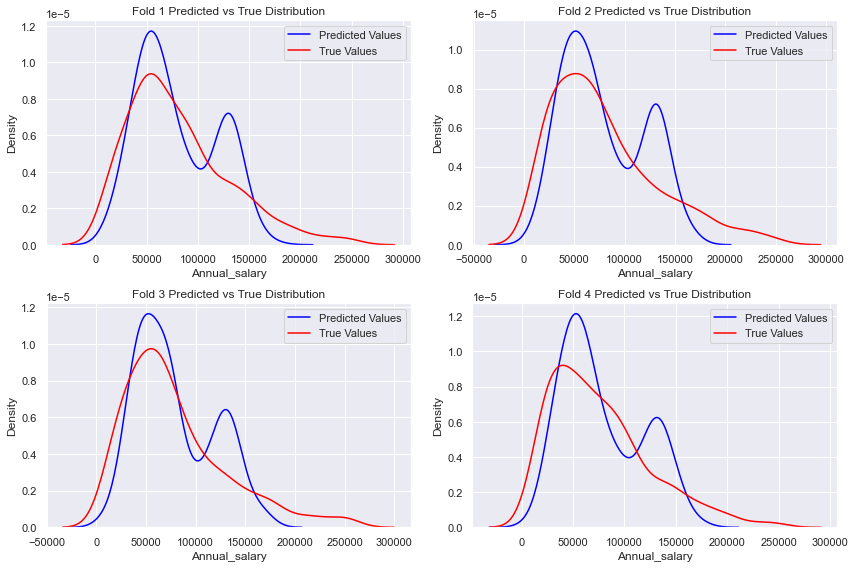

In [66]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    # Extrae los datos para este fold específico
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    # Realiza las predicciones para este fold
    y_fold_pred = clf.predict(X_fold_test)

    # Crear un subplot para cada fold
    plt.subplot(2, 2, fold_num)
    sns.kdeplot(y_fold_pred, color='blue', label='Predicted Values')
    sns.kdeplot(y_fold_true, color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1

plt.tight_layout()
plt.show()

Now, the average of folds:

In [67]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  

print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Test R2: 0.6217493416665298
Mean CV Test RMSE: 31229.187070019205


### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [68]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train set results

In [69]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")


Train set metrics:
R^2: 0.6503408477537569
RMSE: 30073.831566738885
Adjusted R^2: 0.6291444047839423


In [70]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")


Test set metrics:
R^2: 0.6522486325975481
RMSE: 29221.439666154423
Adjusted R^2: 0.5461967971485733


In [71]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

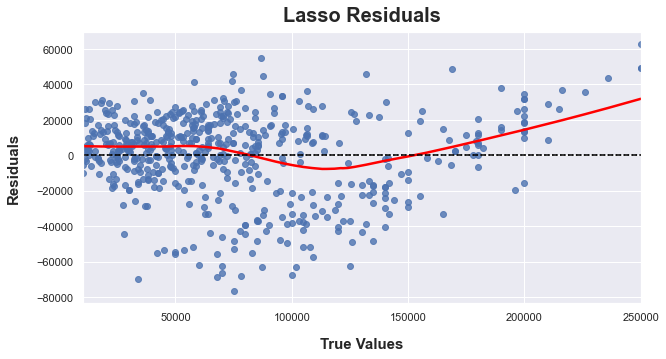

In [72]:
sns.set_theme(style='darkgrid')

residuals = y_test - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('Lasso Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/lasso-test-residuals.pdf");

In [73]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Ajustando un modelo OLS
X_with_const = sm.add_constant(X_train_scaled)  # Añadir una constante (intercepto) a las características
ols_model = sm.OLS(y_train, X_with_const).fit()

# Prueba de Breusch-Pagan
bp_test = het_breuschpagan(ols_model.resid, ols_model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("Breusch-Pagan Test:")
for value, label in zip(bp_test, labels):
    print(f"{label}: {value}")

# Prueba de White
white_test = het_white(ols_model.resid, ols_model.model.exog)
labels_white = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("\nWhite Test:")
for value, label in zip(white_test, labels_white):
    print(f"{label}: {value}")

Breusch-Pagan Test:
LM Statistic: 488.31479771015006
LM-Test p-value: 3.2458656016970997e-43
F-Statistic: 4.78732784076996
F-Test p-value: 1.2081882568349448e-52

White Test:
LM Statistic: 2093.6557619192863
LM-Test p-value: 0.7087753049263915
F-Statistic: 0.759582432527431
F-Test p-value: 0.9879348618869381


### 4.2. Test set performance

<Figure size 720x432 with 0 Axes>

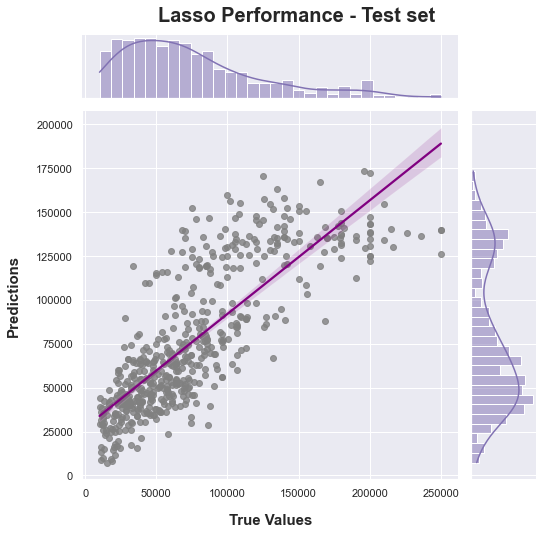

In [74]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=y_test, y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('Lasso Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/lasso-test-predictions.pdf");

## 6. Saving results

Saving CV results

In [75]:
df_cv_results.to_csv("../../output/lasso-cv-results.csv", index=False)

Saving train and test sets predictions

In [76]:
np.savetxt("../../output/lasso-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/lasso-test-predictions.csv", y_pred_test, delimiter=",")

## 7. Others

For Lasso, let's also see the feature importance

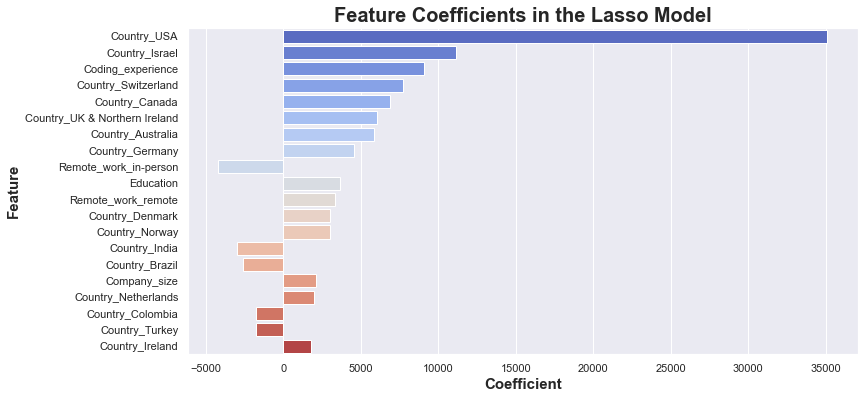

In [77]:
# Get the feature coefficients
coefficients = clf.best_estimator_.coef_

# Get the feature names from the DataFrame
feature_names = X_train.columns

# Create a DataFrame with the feature names and their corresponding coefficients
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefficients})

# Sort the DataFrame by the absolute value of the coefficients in descending order
coef_df = coef_df.reindex(coef_df.coef.abs().sort_values(ascending=False).index)

# Only keep the top 15 most relevant coefficients
coef_df = coef_df.head(20)

# Create a bar plot of the feature coefficients
plt.figure(figsize=(12, 6))  # Adjusted the figure size for better visibility
sns.barplot(data=coef_df, x='coef', y='feature', palette='coolwarm')

# Customizing the labels and title
plt.xlabel('Coefficient', fontsize=15, weight='bold')
plt.ylabel('Feature', fontsize=15, weight='bold')
plt.title('Feature Coefficients in the Lasso Model', fontsize=20, weight='bold')

# Display the plot
plt.show()
